# SIR ODE History Matching

This tutorial will cover the use of history matching on an SIR (Susceptible-Infectious-Recovered) compartmental model, composed of ordinary differential equations.

We can think of black-box optimisation as iteratively exploring the input space of the SIR model to find a best solution (in the case of single-objective optimisation) or a set of best solutions (for multi-objective optimisation), without needing access to or derivatives of the internal equations.

By contrast, history matching is used to systematically rule out regions of the model's input space that are inconsistent with observed daily infection data. Instead of seeking a single "best-fit" parameter set, it identifies the ensemble of plausible parameter combinations that produce model outputs in agreement with observed daily infections, accounting for observational uncertainty and model structural limitations. 

Iteratively, implausible regions of parameter space are excluded, narrowing down to a set of non-implausible parameter combinations that inform model calibration. [More information on history matching can be found here](https://mogp-emulator.readthedocs.io/en/latest/methods/thread/ThreadGenericHistoryMatching.html).

In [1]:
import pandas as pd
import numpy as np
from calisim.example_models import SirOdesModel
import os.path as osp
import os
import shutil

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)

from calisim.history_matching import (
	HistoryMatchingMethod,
	HistoryMatchingMethodModel,
)


# Observed data

We will next load the observed field data.

In [2]:
model = SirOdesModel()
observed_data = model.get_observed_data()
observed_data

,dotS,dotI,dotR,day
0,999.000000,1.000000,0.000000,0
1,998.534208,1.349201,0.116592,1
2,997.906105,1.819995,0.273899,2
3,997.059813,2.454180,0.486007,3
4,995.919926,3.308098,0.771976,4
5,994.385263,4.457212,1.157524,5
6,992.323001,6.000336,1.676664,6
7,989.556810,8.068764,2.374426,7
8,985.847074,10.839686,3.313240,8
9,980.887285,14.538527,4.574189,9


In [3]:
reference_parameters = model.GROUND_TRUTH.copy()
reference_parameters

{'beta': 0.4, 'gamma': 0.1, 'N': 1000, 'I0': 1.0, 'R0': 0, 'S0': 999.0}

# Calibration procedure

## Iterative ensemble smoother

We will next run the calibration procedures against observed daily infections. In this case, we will perform history matching via [the iterative ensemble smoother package](https://iterative-ensemble-smoother.readthedocs.io/en/latest/index.html).

We begin by specifying our parameter distributions. We will calibrate 2 parameters:

- β (beta) = Infection rate: how fast the disease spreads (contact × transmission prob).
- γ (gamma) = Recovery rate: how fast people recover (≈ 1 / infectious period).

Note that we are using Normal distributions for our parameters, as the iterative ensemble smoother update step is parametric and assumes Gaussianity in the joint distribution of parameters and observations. More on that later...

In [4]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="beta",
			distribution_name="normal",
			distribution_args=[0.4, 0.1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="gamma",
			distribution_name="normal",
			distribution_args=[0.1, 0.02],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We'll define a history matching function that will return the simulated daily infections. 

In [6]:
def history_matching_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None, t: pd.Series
) -> float | list[float]:
    model = SirOdesModel()
    simulation_parameters = reference_parameters.copy()
    simulation_parameters["t"] = t
    
    for k in ["beta", "gamma"]:
        simulation_parameters[k] = parameters[k]
        
    simulated_data = model.simulate(simulation_parameters).dotI.values
    return simulated_data

The iterative ensemble smoother will thereafter create an ensemble of SIR simulations from the joint distribution of our parameter specifications. Each ensemble member is run through the model and compared to observations, and the ensemble is updated iteratively using a Kalman-like gain: 

$$
    \mathbf{m}^{(k+1)} = \mathbf{m}^{(k)} + \mathbf{C}_{md} (\mathbf{C}_{dd} + \mathbf{R})^{-1} (\mathbf{d}_{obs} - \mathbf{d}^{(k)})
$$

where:  
- $\mathbf{m}^{(k)}$ = ensemble of parameters at iteration $k$  
- $\mathbf{d}^{(k)}$ = simulated observations for ensemble  
- $\mathbf{d}_{obs}$ = actual observations  
- $\mathbf{C}_{md}$ = cross-covariance between parameters and simulated observations  
- $\mathbf{C}_{dd}$ = covariance of simulated observations  
- $\mathbf{R}$ = observation error covariance  
    
Ensemble members move toward regions that better match the data, and will eventually concentrate in plausible regions after several iterations. [More information on the iterative ensemble smoother can be found here](https://www.frontiersin.org/articles/10.3389/fams.2019.00047/full).

For demonstration purposes, we will use an ensemble size of **M** = 25 and 10 iterations.

SIES iteration 1/10
SIES iteration 2/10
SIES iteration 3/10
SIES iteration 4/10
SIES iteration 5/10
SIES iteration 6/10
SIES iteration 7/10
SIES iteration 8/10
SIES iteration 9/10
SIES iteration 10/10


/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/calisim/base/calibration_base.py:427: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


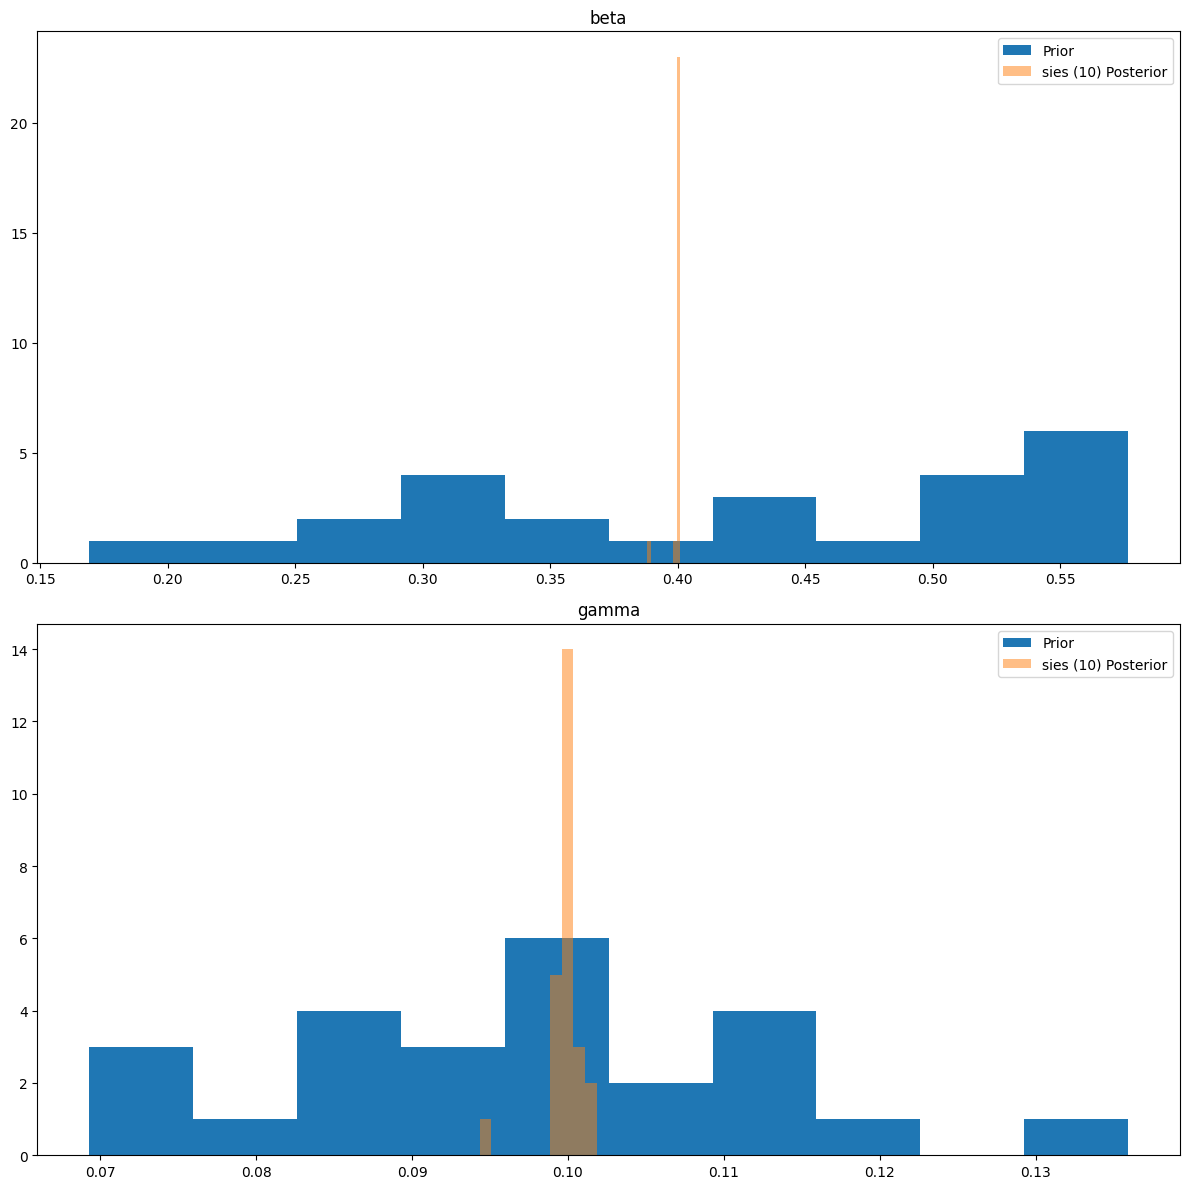

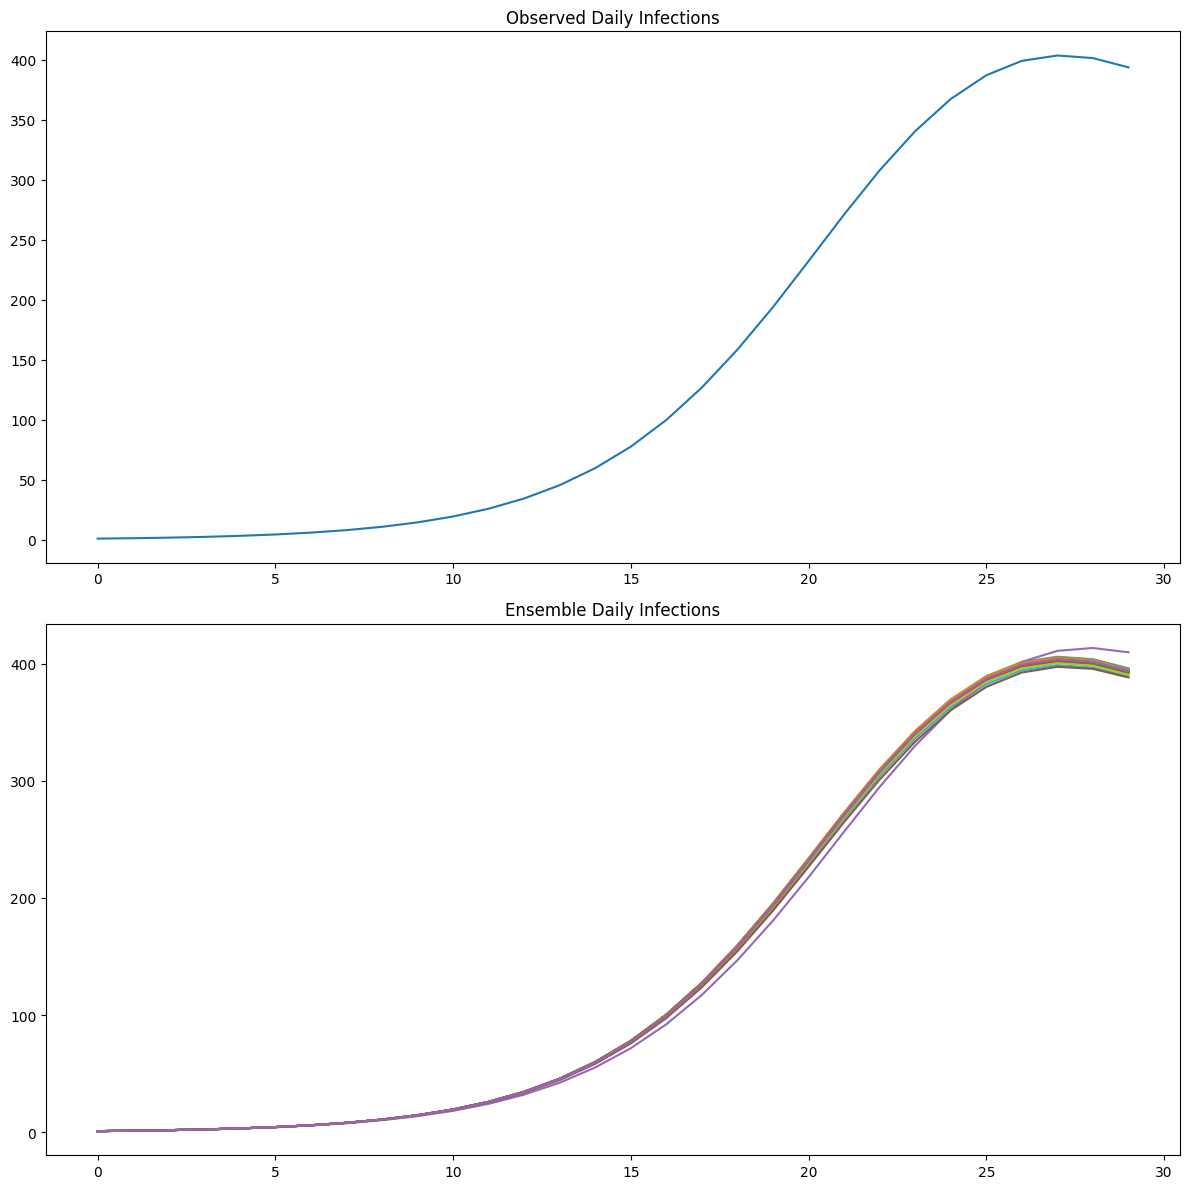

In [7]:
specification = HistoryMatchingMethodModel(
	experiment_name="ies_history_matching",
	parameter_spec=parameter_spec,
	observed_data=observed_data.dotI.values,
	method="sies",
	n_samples=25,
	n_iterations=10,
	output_labels=["Daily Infections"],
	verbose=True,
	batched=False,
	covariance=np.eye(observed_data.dotI.values.shape[0]),
	method_kwargs=dict(truncation=1.0),
    calibration_func_kwargs=dict(t=observed_data.day),
)

calibrator = HistoryMatchingMethod(
	calibration_func=history_matching_func, specification=specification, engine="ies"
)

calibrator.specify().execute().analyze()

We can see the difference between our prior distribution (the parameter specification), and posterior distribution (the plausible distribution of parameter values post-history matching).

In the plot above, we can see the ensemble trajectories of daily infections. The ensemble spread appears to be relatively small, and our model seems to be well calibrated following the use of history matching.

The uncertainty of the estimate of beta is smaller than that of gamma.

In [9]:
hm_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
hm_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,beta,0.399576,0.002418
1,gamma,0.099831,0.001315


We see the probabilistic parameter estimates above for our 2 parameters, offering both point estimates and some measure of uncertainty (the posterior mean and standard deviation respectively). We can run the SIR model again using these calibrated estimates, and compare the simulated and observed daily infections.

<Axes: xlabel='observed', ylabel='simulated'>

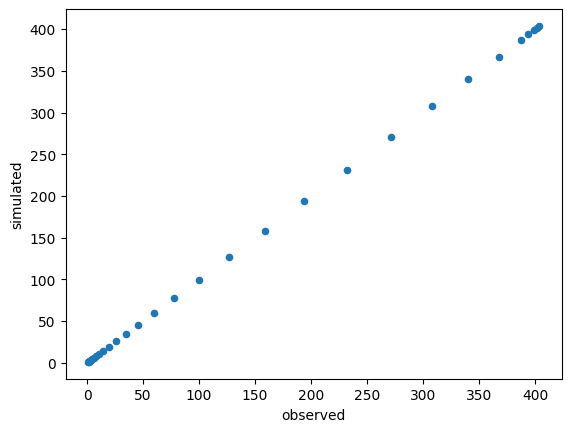

In [11]:
parameters = { 
    row["parameter_name"]: row["parameter_estimate"]
    for row in hm_df.to_dict("records")
}

optimised_parameters = reference_parameters.copy()
optimised_parameters["t"] = observed_data.day
for k in parameters:
    optimised_parameters[k] = parameters[k]
    
pd.DataFrame({
    "observed": observed_data.dotI.values,
    "simulated": model.simulate(optimised_parameters).dotI.values
}).plot.scatter("observed", "simulated")

After calibration via history matching, the predictive accuracy of our SIR model is quite high. The model's behaviour more closely reflects that of reality.

## Ensemble smoother with multiple data assimilation 

One advantage of calisim is its modular nature. We can easily switch between different calibration packages and algorithms with minimal code changes. [Let's switch to using the pyESMDA package](https://pyesmda.readthedocs.io/en/stable/). 

This library uses the ensemble smoother with multiple data assimilation (ESMDA) algorithm. [More information on ESMDA can be found here](https://www.sciencedirect.com/science/article/abs/pii/S0098300412000994).

Assimilation # 1
Assimilation # 2
Assimilation # 3
Assimilation # 4
Assimilation # 5
Assimilation # 6
Assimilation # 7
Assimilation # 8
Assimilation # 9
Assimilation # 10


/home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/calisim/base/calibration_base.py:427: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


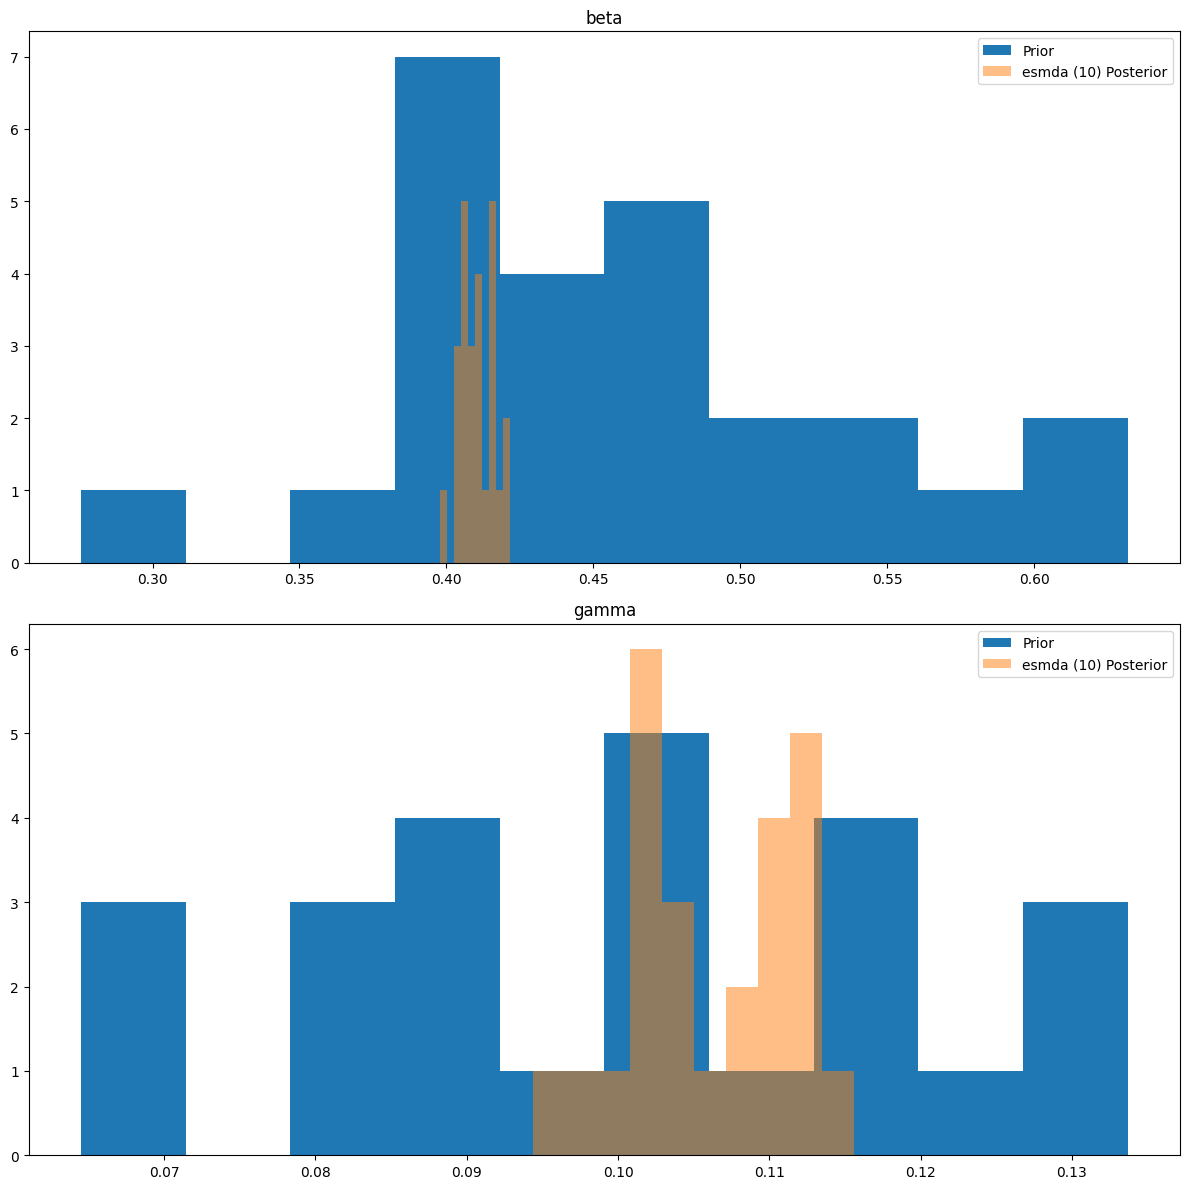

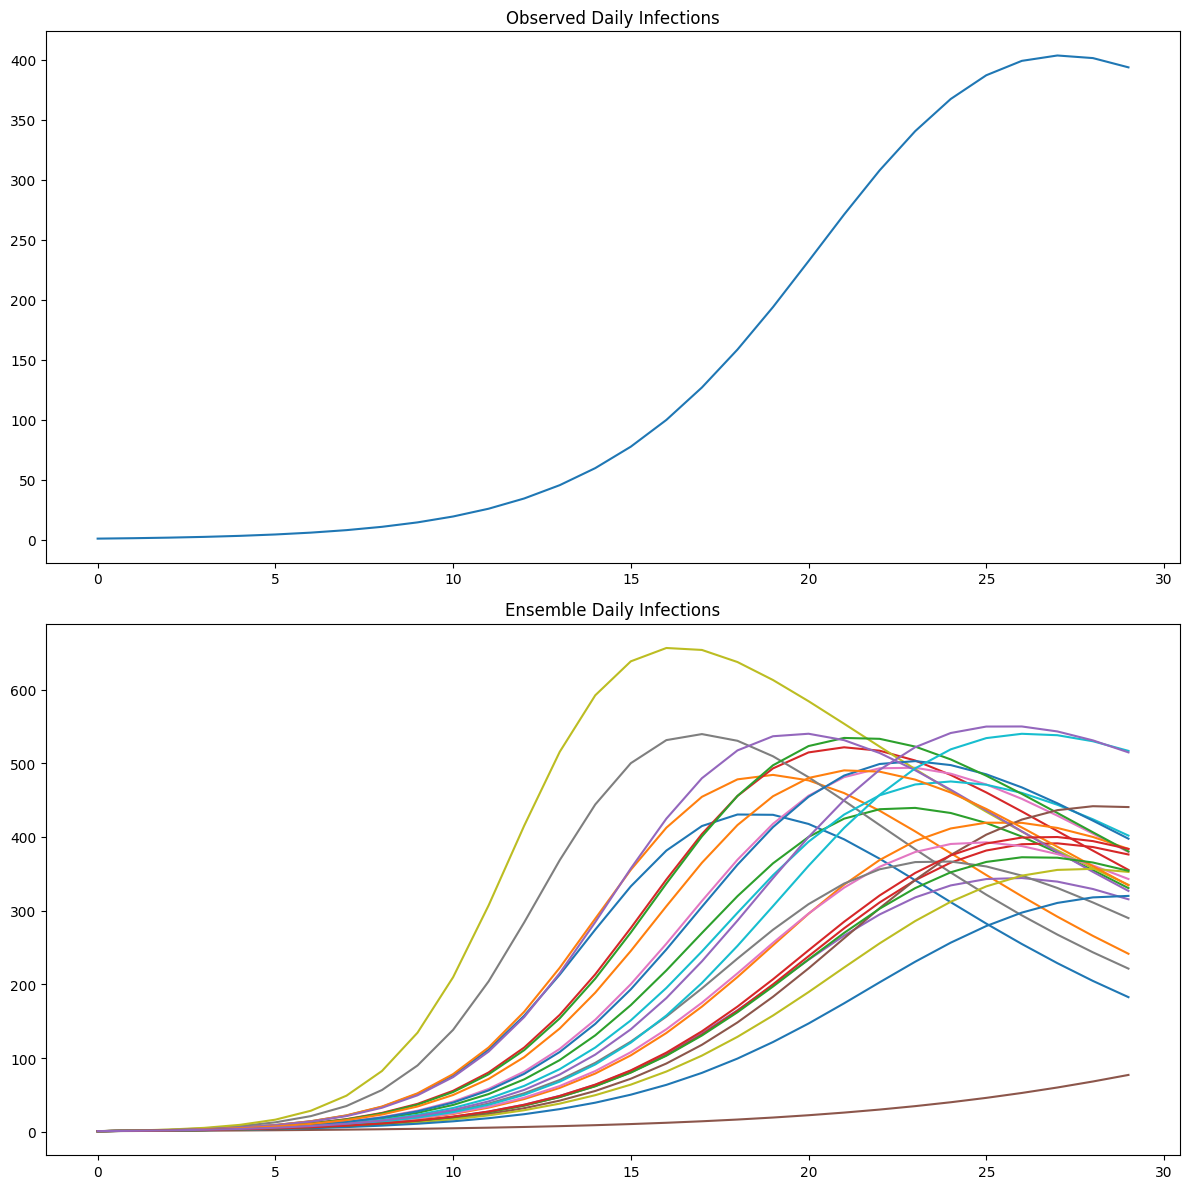

In [13]:
specification = HistoryMatchingMethodModel(
	experiment_name="pyesmda_history_matching",
	parameter_spec=parameter_spec,
	observed_data=observed_data.dotI.values,
	method="esmda",
	n_samples=25,
	n_iterations=10,
	output_labels=["Daily Infections"],
	verbose=True,
	batched=False,
	covariance=np.eye(observed_data.dotI.values.shape[0]),
	method_kwargs=dict(save_ensembles_history=True),
    calibration_func_kwargs=dict(t=observed_data.day),
)

calibrator = HistoryMatchingMethod(
	calibration_func=history_matching_func, specification=specification, engine="pyesmda"
)

calibrator.specify().execute().analyze()

Hence, a secondary use for calisim is library and algorithm benchmarking, critique, and comparison.

In [14]:
hm_df = pd.DataFrame({
    "parameter_name": [ 
        model.name
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "parameter_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
})
hm_df

,parameter_name,parameter_estimate,parameter_uncertainty
0,beta,0.410284,0.006039
1,gamma,0.106178,0.005420


We see the probabilistic parameter estimates above for our 2 parameters, offering both point estimates and some measure of uncertainty. We can run the SIR model again using these calibrated estimates, and compare the simulated and observed daily infections.

<Axes: xlabel='observed', ylabel='simulated'>

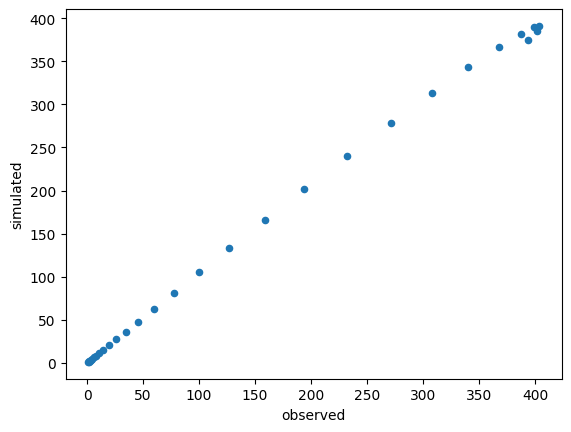

In [15]:
parameters = { 
    row["parameter_name"]: row["parameter_estimate"]
    for row in hm_df.to_dict("records")
}

optimised_parameters = reference_parameters.copy()
optimised_parameters["t"] = observed_data.day
for k in parameters:
    optimised_parameters[k] = parameters[k]
    
pd.DataFrame({
    "observed": observed_data.dotI.values,
    "simulated": model.simulate(optimised_parameters).dotI.values
}).plot.scatter("observed", "simulated")

The predictive accuracy of the calibrated model is quite good. Although IES appears to out-perform it.